In [65]:
#%load_ext autoreload
#%autoreload 2

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from scipy.linalg import expm
import numpy as np
import pandas as pd
import os
import scipy.io
import neuronumba
import scipy.integrate as integrate
from scipy.linalg import expm
from scipy.linalg import solve_continuous_lyapunov
from DataLoaders.baseDataLoader import DataLoader
import ADNI_A
from functions_FDT_numba_v8 import *
from functions_boxplots_WN3_v0 import *
from functions_violinplots_WN3_v0 import *
from functions_FDT_numba_v8 import construct_matrix_A, Integrate_Langevin_ND_Optimized, closest_valid_M
import filterps
from functions_violinplots_WN3_v0 import plot_violins_HC_MCI_AD
from typing import Union
from numba import njit, prange, objmode
from functions_FC_v2 import plot_FC_matrices


In [ ]:
# --- Numba-fied Hopf Model and Loss ---

@njit # Numba decorator for this helper
def construct_jacobian_numba(N, a_param, gC, B, wo):
    """Helper to construct Jacobian matrix A in a Numba-compatible way."""
    A = np.zeros((2 * N, 2 * N), dtype=np.float64)

    Axx_block = a_param * np.eye(N) - B + gC
    A[:N, :N] = Axx_block
    A[N:, N:] = Axx_block # Axx = Ayy in this model

    for i in range(N):
        A[i, N + i] = -wo[i] # Axy
        A[N + i, i] = wo[i]  # Ayx
    return A

@njit # Numba decorator for this helper
def construct_Qn_numba(N, sigma_sq_elements):
    """Helper to construct noise covariance Qn in a Numba-compatible way."""
    # sigma_sq_elements should be sigma_i^2 for each node i
    Qn_diag = np.concatenate((sigma_sq_elements, sigma_sq_elements))
    Qn = np.diag(Qn_diag)
    return Qn

@njit
def hopf_int_numba_internal(gC, f_diff, sigma_array, a_param=-0.02):
    """
    Computes the linearized Hopf model FC and Covariance. Numba-optimized internals.
    sigma_array: 1D array of noise standard deviations for each node.
    """
    N = gC.shape[0]
    wo = f_diff * (2 * np.pi)

    s = np.sum(gC, axis=1)
    B = np.diag(s)

    # Renamed A to A_jac to avoid potential confusion if A had other meanings.
    A_jac = construct_jacobian_numba(N, a_param, gC, B, wo)

    sigma_sq_elements = np.empty(N, dtype=sigma_array.dtype)
    for i in range(N):
        sigma_sq_elements[i] = sigma_array[i] * sigma_array[i]

    Qn = construct_Qn_numba(N, sigma_sq_elements)

    with objmode(objmode_sylvester_result='float64[:,:]'):
        try:
            _temp_solved_sylvester = scipy.linalg.solve_sylvester(A_jac, A_jac.T, -Qn)
            if not np.isfinite(_temp_solved_sylvester).all():
                objmode_sylvester_result = np.full((2 * N, 2 * N), np.nan, dtype=np.float64)
            else:
                objmode_sylvester_result = _temp_solved_sylvester
        except Exception: 
            objmode_sylvester_result = np.full((2 * N, 2 * N), np.nan, dtype=np.float64)
    
    Cvth = objmode_sylvester_result

    # Prepare default NaN matrices for early returns if needed
    # Ensure dtype matches what successful computation would produce (usually float64 from gC)
    nan_FC_NxN = np.full((N,N), np.nan, dtype=gC.dtype) 
    nan_CV_NxN = np.full((N,N), np.nan, dtype=gC.dtype)

    if np.isnan(Cvth).any():
        # Cvth is already NaN from objmode block if solver failed.
        # A_jac is computed before Cvth, so it's available.
        return nan_FC_NxN, nan_CV_NxN, Cvth, A_jac # Return 4 items

    CV = Cvth[:N, :N].copy()

    diag_CV = np.diag(CV)
    if np.any(diag_CV < -1e-9): # Allow small negative due to numerical errors
        # FC will be NaN. CV is the computed (but problematic) one. Cvth & A_jac are available.
        return nan_FC_NxN, CV, Cvth, A_jac # Return 4 items

    diag_CV_clipped = np.maximum(diag_CV, 0.0)
    std_dev = np.sqrt(diag_CV_clipped)

    FC = np.eye(N, dtype=gC.dtype) 
    for i in range(N):
        for j in range(i + 1, N): 
            if std_dev[i] > 1e-9 and std_dev[j] > 1e-9:
                corr_val = CV[i, j] / (std_dev[i] * std_dev[j])
                FC[i, j] = min(max(corr_val, -1.0), 1.0)
                FC[j, i] = FC[i, j] 
            
    return FC, CV, Cvth, A_jac # Successful return: 4 items

@njit
def hopf_int_numba_wrapper(gC, f_diff, sigma, a_param=-0.02):
    return hopf_int_numba_internal(gC, f_diff, sigma, a_param)

@njit
def calculate_loss_numba(sigma, gC, f_diff, target_FC,
                         target_CV, use_CV, weight_CV, a_param,
                         fc_indices_row, fc_indices_col,
                         cv_indices_row, cv_indices_col,
                         min_sigma_val):
    """ Numba-compatible loss calculation. """
    current_sigma = np.empty_like(sigma)
    for i in range(len(sigma)):
        current_sigma[i] = max(sigma[i], min_sigma_val)

    model_FC, model_CV, _, _ = hopf_int_numba_wrapper(gC, f_diff, current_sigma, a_param)

    if np.isnan(model_FC).any() or (use_CV and np.isnan(model_CV).any()):
        return np.inf

    loss_FC = 0.0
    num_fc_elements = len(fc_indices_row)
    if num_fc_elements > 0:
        for i in range(num_fc_elements):
            loss_FC += (model_FC[fc_indices_row[i], fc_indices_col[i]] - \
                        target_FC[fc_indices_row[i], fc_indices_col[i]])**2
        loss_FC = loss_FC / num_fc_elements
    
    loss_total = loss_FC

    if use_CV:
        loss_CV = 0.0
        num_cv_elements = len(cv_indices_row)
        if num_cv_elements > 0:
            for i in range(num_cv_elements):
                loss_CV += (model_CV[cv_indices_row[i], cv_indices_col[i]] - \
                            target_CV[cv_indices_row[i], cv_indices_col[i]])**2
            loss_CV = loss_CV / num_cv_elements
        loss_total = (1.0 - weight_CV) * loss_FC + weight_CV * loss_CV
    return loss_total


# --- Stochastic Gradient Implementation ---

@njit(parallel=True)
def numerical_gradient_numba(sigma, gC, f_diff, target_FC, target_CV, use_CV, weight_CV, a_param,
                             fc_indices_row, fc_indices_col, cv_indices_row, cv_indices_col,
                             min_sigma_val, epsilon=1e-5):
    """ Computes numerical gradient of calculate_loss_numba w.r.t. sigma in parallel. """
    N_sigma = sigma.shape[0]
    grad = np.empty(N_sigma, dtype=sigma.dtype)

    for i in prange(N_sigma): # Parallel loop
        sigma_plus = sigma.copy()
        sigma_plus[i] += epsilon
        
        sigma_minus = sigma.copy()
        sigma_minus[i] -= epsilon
        
        loss_plus = calculate_loss_numba(sigma_plus, gC, f_diff, target_FC, target_CV, use_CV, weight_CV, a_param,
                                         fc_indices_row, fc_indices_col, cv_indices_row, cv_indices_col, min_sigma_val)
        
        loss_minus = calculate_loss_numba(sigma_minus, gC, f_diff, target_FC, target_CV, use_CV, weight_CV, a_param,
                                          fc_indices_row, fc_indices_col, cv_indices_row, cv_indices_col, min_sigma_val)
        
        if np.isinf(loss_plus) and np.isinf(loss_minus):
            grad[i] = 0.0 
        elif np.isinf(loss_plus): 
            loss_curr = calculate_loss_numba(sigma, gC, f_diff, target_FC, target_CV, use_CV, weight_CV, a_param,
                                             fc_indices_row, fc_indices_col, cv_indices_row, cv_indices_col, min_sigma_val)
            if np.isinf(loss_curr): grad[i] = 0.0 
            else: grad[i] = (loss_curr - loss_minus) / epsilon
        elif np.isinf(loss_minus): 
            loss_curr = calculate_loss_numba(sigma, gC, f_diff, target_FC, target_CV, use_CV, weight_CV, a_param,
                                             fc_indices_row, fc_indices_col, cv_indices_row, cv_indices_col, min_sigma_val)
            if np.isinf(loss_curr): grad[i] = 0.0 
            else: grad[i] = (loss_plus - loss_curr) / epsilon
        else: 
            grad[i] = (loss_plus - loss_minus) / (2 * epsilon)
            
        if np.isnan(grad[i]): 
            grad[i] = 0.0 
            
    return grad

# SGD Implementation
def stochastic_gradient_descent(gC, f_diff, target_FC,
                                initial_sigma,
                                learning_rate=0.01,
                                n_iterations=1000,
                                target_CV=None, use_CV=False, weight_CV=0.5,
                                a_param=-0.02,
                                stochastic_subset_fc=0,
                                stochastic_subset_cv=0,
                                epsilon_gradient=1e-5,
                                patience=50, tol=1e-7,
                                min_sigma_val=1e-7):
    """ Performs Stochastic Gradient Descent to optimize sigma. """
    N = gC.shape[0]
    sigma = initial_sigma.copy()
    loss_history = []

    idx_fc_upper_all_rows, idx_fc_upper_all_cols = np.triu_indices(N, k=1)
    # Ensure they are int64 for Numba if they could be other int types from numpy
    idx_fc_upper_all_rows = idx_fc_upper_all_rows.astype(np.int64)
    idx_fc_upper_all_cols = idx_fc_upper_all_cols.astype(np.int64)

    idx_cv_upper_all_rows, idx_cv_upper_all_cols = np.triu_indices(N, k=0)
    idx_cv_upper_all_rows = idx_cv_upper_all_rows.astype(np.int64)
    idx_cv_upper_all_cols = idx_cv_upper_all_cols.astype(np.int64)

    best_loss = np.inf
    epochs_no_improve = 0

    print(f"Starting SGD: LR={learning_rate}, Iterations={n_iterations}, Patience={patience}, Tol={tol}")
    print(f"Stochastic FC subset: {stochastic_subset_fc if stochastic_subset_fc > 0 else 'All'}")
    if use_CV:
        print(f"Stochastic CV subset: {stochastic_subset_cv if stochastic_subset_cv > 0 else 'All'}")


    for iteration in range(1, n_iterations + 1):
        current_fc_indices_row = idx_fc_upper_all_rows
        current_fc_indices_col = idx_fc_upper_all_cols
        if stochastic_subset_fc > 0 and len(idx_fc_upper_all_rows) > stochastic_subset_fc:
            sample_indices_fc = np.random.choice(len(idx_fc_upper_all_rows), stochastic_subset_fc, replace=False)
            current_fc_indices_row = idx_fc_upper_all_rows[sample_indices_fc]
            current_fc_indices_col = idx_fc_upper_all_cols[sample_indices_fc]

        current_cv_indices_row = idx_cv_upper_all_rows # Default to all even if not used by Numba func
        current_cv_indices_col = idx_cv_upper_all_cols # Default to all even if not used by Numba func
        if use_CV:
            if stochastic_subset_cv > 0 and len(idx_cv_upper_all_rows) > stochastic_subset_cv:
                sample_indices_cv = np.random.choice(len(idx_cv_upper_all_rows), stochastic_subset_cv, replace=False)
                current_cv_indices_row = idx_cv_upper_all_rows[sample_indices_cv]
                current_cv_indices_col = idx_cv_upper_all_cols[sample_indices_cv]
        else: # Pass empty int64 arrays if CV not used
            current_cv_indices_row = np.empty(0, dtype=np.int64) 
            current_cv_indices_col = np.empty(0, dtype=np.int64)

        grad = numerical_gradient_numba(sigma, gC, f_diff, target_FC, target_CV, use_CV, weight_CV, a_param,
                                        current_fc_indices_row, current_fc_indices_col,
                                        current_cv_indices_row, current_cv_indices_col,
                                        min_sigma_val, epsilon_gradient)
        
        if np.any(np.isnan(grad)): 
            print(f"Iteration {iteration}: NaN in gradient: {grad}. Sigma: {sigma}. Stopping.")
            break
        if np.any(np.isinf(grad)):
            print(f"Iteration {iteration}: Inf in gradient: {grad}. Sigma: {sigma}. Stopping.")
            break

        sigma -= learning_rate * grad
        sigma = np.maximum(sigma, min_sigma_val) 

        current_loss = calculate_loss_numba(sigma, gC, f_diff, target_FC, target_CV, use_CV, weight_CV, a_param,
                                            idx_fc_upper_all_rows, idx_fc_upper_all_cols,
                                            idx_cv_upper_all_rows, idx_cv_upper_all_cols, min_sigma_val)
        loss_history.append(current_loss)

        if iteration % 20 == 0 or iteration == n_iterations : 
            sigma_str = ", ".join([f"{s:.4f}" for s in sigma])
            # print(f"Iter {iteration:4d}/{n_iterations}, Loss: {current_loss:.7f}, Sigma: [{sigma_str}]")
            print(f"Iter {iteration:4d}/{n_iterations}, Loss: {current_loss:.7f}]")

        if current_loss < best_loss - tol:
            best_loss = current_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping at iteration {iteration} (loss: {current_loss:.7f}).")
            break
            
    return sigma, loss_history

# --- Useful functions ---
### Implementation of Matlab's xcov ###
import numpy as np
from scipy.signal import correlate

def xcov(x, y, Tau, norm='none'):
    """
    Replicate MATLAB's xcov behavior in Python.

    Parameters:
        x, y: Input signals (1D arrays).
        Tau: Maximum lag (integer).
        norm: Normalization option ('none', 'coeff').

    Returns:
        clag: Cross-covariance or cross-correlation values.
        lags: Corresponding lags in the range [-Tau, Tau].
    """
    # Remove the mean from the signals
    x = x - np.mean(x)
    y = y - np.mean(y)

    # Compute full cross-correlation
    full_corr = correlate(x, y, mode='full')

    # Compute all possible lags
    len_x, len_y = len(x), len(y)
    full_lags = np.arange(-len_x + 1, len_y)

    # Limit to lags in the range [-Tau, Tau]
    valid_indices = (full_lags >= -Tau) & (full_lags <= Tau)
    clag = full_corr[valid_indices]
    lags = full_lags[valid_indices]

    # Apply normalization if requested
    if norm == 'coeff':
        # Normalize so that zero-lag coefficient is 1
        x_norm = x / np.linalg.norm(x)
        y_norm = y / np.linalg.norm(y)
        full_corr = correlate(x_norm, y_norm, mode='full')
        clag = full_corr[valid_indices]

    return clag, lags

### Objective function to generate first guess fitting ###
def objective_function_FC(sigma, gC, f_diff, FCemp, a_param, metric='fro'):
    """
    Computes the combined error for fitting both FC and COVtau.
    Parameters:
        sigma: Array of noise variances
        gC: Connectivity matrix
        f_diff: Frequency differences
        FCemp: Empirical functional connectivity matrix
        metric: metrics to use
            fro: Frobenius
            mse: Mean Squared Error
            mae: Mean Absolute Error
    Returns:
        Total Error: errors for FC
    """
    ## Compute the simulated FC, COVsim, and COVtau
    FCsim, _, _, _ = hopf_int_numba_wrapper(gC, f_diff, sigma, a_param)
    N = gC.shape[0]
    ## Compute errors
    ## Frobenius
    if metric == 'fro': # Frobenius norm for FC and COVtau
        fc_error = np.linalg.norm(FCsim - FCemp, ord='fro')
    ## MSE
    if metric == 'mse': # Mean squared error for FC and COVtau
        fc_error = np.mean((FCsim - FCemp) ** 2)
    ## MAE
    if metric == 'mae': # Mean absolute error for FC and COVtau
        fc_error = np.mean(np.abs(FCsim - FCemp))
    # Combined fro + mse + ssim errors
    if metric == 'combined':
        fc_error_fro = np.linalg.norm(FCsim - FCemp, ord='fro')
        fc_error_mse = np.mean((FCsim - FCemp) ** 2)
        fc_error = fc_error_fro + fc_error_mse
    return fc_error

def calc_H_freq(
        all_HC_fMRI: Union[np.ndarray, dict], 
        tr: float, 
        version: filterps.FiltPowSpetraVersion=filterps.FiltPowSpetraVersion.v2021
    ):
        """
        Compute H freq for each node. 
        
        Parameters
        ----------
        all_HC_fMRI: The fMRI of the "health control" group. Can be given in a dictionaray format, 
                     or in an array format (subject, time, node).
                     NOTE: that the signals must already be filitered. 
        tr: TR in milliseconds
        version: Version of FiltPowSpectra to use

        Returns
        -------
        The h frequencies for each node
        """
        f_diff = filterps.filt_pow_spetra_multiple_subjects(all_HC_fMRI, tr, version)
        return f_diff 

# Normalize the timeseries to have a distribution between -0.5 and 0.5 for each node
def normalize_timeseries(ts):
    """
    Normalize the timeseries to have a distribution between -0.5 and 0.5 for each node.
    """
    global_std = np.std(ts)
    scaling_factor = 0.5 / (2 * global_std)  # 2σ spans ~95% of normal data
    ts_scaled = ts * scaling_factor
    return ts_scaled - 1

def normalize_ts_globally(ts, target_std=0.5):
    """
    Normalize time series globally, preserving heterogeneity between parcels.

    Parameters:
        ts (ndarray): shape (parcels, timepoints)
        target_std (float): desired global standard deviation (default 0.5)

    Returns:
        ts_scaled (ndarray): globally scaled time series
    """
    ts_centered = ts - np.mean(ts)  # Global mean removal

    global_std = np.std(ts_centered)

    ts_scaled = ts_centered / global_std * target_std

    return ts_scaled

def initialize_sigma(NPARCELLS, Ceff, f_diff, FCemp, a_param=-0.02, sigma_init_mean=0.11):
    """
    Initialize the sigma values for each parcel.
    """

    # --- Initial guess for sigma ---
    sigma_init_guess = sigma_init_mean * np.ones(NPARCELLS)

    # --- Initial fitting using scipy.minimize ---
    INITIAL_FIT = True
    INITIAL_FIT_NORM = False
    #
    if INITIAL_FIT == False:
        initial_sigma = sigma_init_guess
    elif INITIAL_FIT == True:    
        ## Define bounds for sigma fitting
        sigma_min = sigma_init_mean * 0.75
        sigma_max = sigma_init_mean * 1.25
        bound_min = sigma_min
        bound_max = sigma_max
        bounds = [(bound_min, bound_max)] * NPARCELLS
        ## Select metric ('fro', 'mse', 'mae', 'combined'='fro'+'mse')
        metric = 'combined'
        from scipy.optimize import minimize
        result = minimize(
                fun=objective_function_FC,
                x0=sigma_init_guess,
                args=(Ceff, f_diff, FCemp, a_param, metric),
                method='L-BFGS-B',
                bounds=bounds,
                options={'disp': True, 'maxiter': 10000}
            )
        ## Extract the optimized sigma
        sigma_optimized_minimize = result.x
        ## Normalize
        _, CVsim_opt_fc, _, _ = hopf_int_numba_wrapper(Ceff, f_diff, sigma_optimized_minimize, a_param)
        if not np.isnan(CVsim_opt_fc).any():
            sum_CVsim_opt = np.sum(np.diag(CVsim_opt_fc))
            sum_CVemp = np.sum(np.diag(COVemp))
            if sum_CVsim_opt > 1e-12:
                c = np.sqrt(max(0, sum_CVemp / sum_CVsim_opt))
                sigma_optimized_minimize_norm = sigma_optimized_minimize * c
            else: sigma_optimized_minimize_norm = sigma_optimized_minimize
        else: sigma_optimized_minimize_norm = sigma_optimized_minimize
        initial_sigma_norm = sigma_optimized_minimize_norm
        #
        if INITIAL_FIT_NORM == False:
            ## Use as initial guess
            initial_sigma = sigma_optimized_minimize
        elif INITIAL_FIT_NORM == True:
            ## Normalize and then use as initial guess
            initial_sigma = initial_sigma_norm
    return initial_sigma

def sigma_optimalisation_FC(NPARCELLS,Ceff, f_diff, FCemp, initial_sigma,COVemp,min_sigma_val=1e-7,a_param=-0.02):
    print("\n--- Running SGD (FC only) ---")

    iterations_max = int(800*np.log(NPARCELLS))
    iterations_min = 500

    sigma_opt_sgd_fc, loss_hist_sgd_fc = stochastic_gradient_descent(
        Ceff, f_diff, FCemp, initial_sigma.copy(),
        learning_rate=0.001, 
        n_iterations=max(iterations_min,iterations_max),
        target_CV=COVemp, use_CV=False,
        a_param=a_param,
        stochastic_subset_fc=NPARCELLS*2//3,
        patience=50, tol=1e-6,
        min_sigma_val=min_sigma_val
    )

    #plt.figure(figsize=(10,6))
    #plt.plot(loss_hist_sgd_fc)
    #plt.title('Loss Curve (SGD, FC only)')
    #plt.xlabel('Iteration'); plt.ylabel('Loss'); plt.grid(True); plt.yscale('log')
    #plt.show()

    _, CVsim_opt_fc, _, _ = hopf_int_numba_wrapper(Ceff, f_diff, sigma_opt_sgd_fc, a_param)
    if not np.isnan(CVsim_opt_fc).any():
        sum_CVsim_opt = np.sum(np.diag(CVsim_opt_fc))
        sum_CVemp = np.sum(np.diag(COVemp))
        if sum_CVsim_opt > 1e-12:
            c = np.sqrt(max(0, sum_CVemp / sum_CVsim_opt))
            sigma_final_norm_fc = sigma_opt_sgd_fc * c
            print(f"Sigma (FC only SGD) scaling coeficcient: {c}")
        else: sigma_final_norm_fc = sigma_opt_sgd_fc
    else: sigma_final_norm_fc = sigma_opt_sgd_fc

    return sigma_final_norm_fc, loss_hist_sgd_fc

        

In [14]:
# --- Compilation of numba functions ---
xNPARCELS = 1
xgC = Ceff[0:xNPARCELS, 0:xNPARCELS].copy()
xf_diff = f_diff[0:xNPARCELS].copy()

print("Warming up Numba functions...")
_fc_indices_rows, _fc_indices_cols = np.triu_indices(xNPARCELS, k=1, m=xNPARCELS)
_fc_indices_rows = _fc_indices_rows.astype(np.int64) # Ensure type
_fc_indices_cols = _fc_indices_cols.astype(np.int64) # Ensure type

_cv_indices_rows, _cv_indices_cols = np.triu_indices(xNPARCELS, k=0, m=xNPARCELS)
_cv_indices_rows = _cv_indices_rows.astype(np.int64) # Ensure type
_cv_indices_cols = _cv_indices_cols.astype(np.int64) # Ensure type

_dummy_sigma = np.ones(xNPARCELS, dtype=np.float64) * 0.1
_dummy_FC = np.eye(xNPARCELS, dtype=np.float64)
_dummy_CV = np.eye(xNPARCELS, dtype=np.float64) # Must be float for Numba if target_CV can be float

_empty_indices = np.empty(0, dtype=np.int64)

try:
    _ = hopf_int_numba_wrapper(xgC, xf_diff, _dummy_sigma, a_param)
    _ = calculate_loss_numba(_dummy_sigma, xgC, xf_diff, _dummy_FC, 
                                _dummy_CV, False, 0.0, a_param, # use_CV=False
                                _fc_indices_rows, _fc_indices_cols, 
                                _empty_indices, _empty_indices, # Pass empty for CV indices when use_CV=False
                                min_sigma_val)
    _ = calculate_loss_numba(_dummy_sigma, xgC, xf_diff, _dummy_FC, 
                                _dummy_CV, True, 0.5, a_param, # use_CV=True
                                _fc_indices_rows, _fc_indices_cols, 
                                _cv_indices_rows, _cv_indices_cols,
                                min_sigma_val)
    _ = numerical_gradient_numba(_dummy_sigma, xgC, xf_diff, _dummy_FC, _dummy_CV, False, 0.0, a_param,
                                    _fc_indices_rows, _fc_indices_cols, _empty_indices, _empty_indices,
                                    min_sigma_val, 1e-5)
    _ = numerical_gradient_numba(_dummy_sigma, xgC, xf_diff, _dummy_FC, _dummy_CV, True, 0.5, a_param,
                                    _fc_indices_rows, _fc_indices_cols, _cv_indices_rows, _cv_indices_cols,
                                    min_sigma_val, 1e-5)
    print("Numba warm-up successful.")
except Exception as e:
    print(f"Error during Numba warm-up: {e}")
    # import traceback
    # traceback.print_exc() # To get more details if needed
    print("Please ensure Numba is installed correctly and system has a compatible C compiler.")
    exit()

del xNPARCELS, xgC, xf_diff

Warming up Numba functions...
Numba warm-up successful.


In [3]:
# Loading the data and data loader

DL = ADNI_A.ADNI_A()

# example of individual
sc = DL.get_subjectData('002_s_0413')
SC = sc['002_s_0413']['SC'] # Structural connectivity

# Loading the data for all subjects
HC_IDs = DL.get_groupSubjects('HC')
HC_MRI = {}
for subject in HC_IDs:
    data = DL.get_subjectData(subject)
    HC_MRI[subject] = data[subject]['timeseries']

MCI_IDs = DL.get_groupSubjects('MCI')
MCI_MRI = {}
for subject in MCI_IDs:
    data = DL.get_subjectData(subject)
    MCI_MRI[subject] = data[subject]['timeseries']

AD_IDs = DL.get_groupSubjects('AD')
AD_MRI = {}
for subject in AD_IDs:
    data = DL.get_subjectData(subject)
    AD_MRI[subject] = data[subject]['timeseries']

# Okay this is loading in the effecetive connectivity, so we cannot use this for f_diff
# we need to use the data loader to get the timeseries data
EC_HC_data = scipy.io.loadmat('ADNI-A_DATA/EC_filterted/HC_FDT_results_filters0109.mat')
EC_MCI_data = scipy.io.loadmat('ADNI-A_DATA/EC_filterted/MCI_FDT_results_filters0109.mat')
EC_AD_data = scipy.io.loadmat('ADNI-A_DATA/EC_filterted/AD_FDT_results_filters0109.mat')
print(EC_HC_data.keys()) # check the keys


cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
dict_keys(['__header__', '__version__', '__globals__', 'Ceff_subjects', 'FDTm_subjects', 'fittCVtau_subjects', 'fittFC_subjects', 'perCeff_subjects', 'perFC_subjects', 'perFDT_subjects'])


### Load empirical data

In [ ]:
### Set conditions
NPARCELLS = 60 #tot: 379
Tau = 1
TR = 2
a_param = -0.02
min_sigma_val = 1e-7
gconst = 1.0
avec = a_param * np.ones(NPARCELLS)
Ndim = 2 * NPARCELLS
v0bias = 0.0
t0 = 0
tfinal = 200
dt = 0.01
times = np.arange(t0, tfinal+dt, dt)

group_names = ['HC', 'MCI', 'AD']
group_sizes = {'HC': len(HC_IDs), 'MCI': len(MCI_IDs), 'AD': len(AD_IDs)}
cond_index_map = {'HC': 0, 'MCI': 1, 'AD': 2}
I_FDT_all = np.full((3, max(group_sizes.values()), NPARCELLS), np.nan)


for i in range(1,4):
    COND = i
    if COND == 1: ## --> HC
        Ceffgroup = EC_HC_data['Ceff_subjects']
        f_diff = calc_H_freq(HC_MRI, 3000, filterps.FiltPowSpetraVersion.v2021)
        ts_gr = HC_MRI
        ID = HC_IDs

    elif COND == 2: ## --> MCI
        Ceffgroup = EC_MCI_data['Ceff_subjects']
        f_diff = calc_H_freq(MCI_MRI, 3000, filterps.FiltPowSpetraVersion.v2021)
        ts_gr = MCI_MRI
        ID = MCI_IDs

    elif COND == 3: ## --> AD
        Ceffgroup = EC_AD_data['Ceff_subjects']
        f_diff = calc_H_freq(AD_MRI, 3000, filterps.FiltPowSpetraVersion.v2021)
        ts_gr = AD_MRI
        ID = AD_IDs
    for sub in range(len(ID)):
        subj_id = ID[sub]
        Ceff = Ceffgroup[sub][:NPARCELLS,:NPARCELLS] # effecitve connectivity
        ts = normalize_timeseries(ts_gr[subj_id][:NPARCELLS,:]) # timeseries
        f_diff = f_diff[:NPARCELLS] # frequencies

        print(np.max(ts),np.min(ts))
        FCemp = np.corrcoef(ts)
        COVemp = np.cov(ts)
        COVtauemp = np.zeros((NPARCELLS, NPARCELLS))
        tst = ts.T
        sigratio = np.zeros((NPARCELLS, NPARCELLS))
        for i in range(NPARCELLS):
            for j in range(NPARCELLS):
                sigratio[i, j] = 1 / np.sqrt(COVemp[i, i]) / np.sqrt(COVemp[j, j])
                clag, lags = xcov(tst[:, i], tst[:, j], Tau, norm='none')
                indx = np.where(lags == Tau)[0][0]
                COVtauemp[i, j] = clag[indx] / tst.shape[0]
        COVtauemp *= sigratio
# Extract the diagonal of the empirical covariance matrix
        COVemp_EM_diag = np.diag(COVemp)

        initial_sigma = initialize_sigma(NPARCELLS, Ceff, f_diff, FCemp)
        sigma_final_norm_fc, loss_sig_fc = sigma_optimalisation_FC(NPARCELLS, Ceff, f_diff, FCemp, initial_sigma, COVemp, min_sigma_val=min_sigma_val, a_param=a_param)
        sigma = sigma_final_norm_fc
        print(sigma)
        sigma = np.append(sigma, sigma)
        v0std = sigma 

        omega = 2 * np.pi * f_diff
        Gamma = -construct_matrix_A(avec, omega, Ceff, gconst)

        v0 = v0std * np.random.standard_normal(Ndim) + v0bias
        vsim, noise = Integrate_Langevin_ND_Optimized(Gamma, sigma, initcond=v0, duration=tfinal, integstep=dt)

        v0 = vsim[:,-1]
        vsim, noise = Integrate_Langevin_ND_Optimized(Gamma, sigma, initcond=v0, duration=tfinal, integstep=dt)
        
        D = np.diag(sigma**2 * np.ones(Ndim))
        V_0 = solve_continuous_lyapunov(Gamma, D)

        #dt = 1.0
        #times = np.arange(t0, tfinal+dt, dt)
        #nsteps = len(times)

        #t_times = times[0:nsteps]
        #s_times = times[0:nsteps]

        #Its_calc = np.zeros((NPARCELLS,len(t_times)))

        #for t in range(len(t_times)):
        #    Its_calc[:,t] = Its_Langevin_ND(Gamma, sigma, V_0, t_times[t], s_times[0])[0:NPARCELLS] # I keep ONLY for the x-components

        tmax = 100
        ts0 = 0
        I_tmax_s0 = Its_Langevin_ND(Gamma, sigma, V_0, tmax, ts0)[0:NPARCELLS]

        group_name = group_names[COND - 1]
        group_idx = cond_index_map[group_name]
        subject_idx = sub  # Already incrementing

        I_FDT_all[group_idx, subject_idx, :] = I_tmax_s0


### Plot connectivity
# plt.imshow(Ceff)
# plt.colorbar()
# plt.show()

# plt.title('Freqs.')
# plt.plot(np.arange(1, NPARCELLS + 1, 1), f_diff[:NPARCELLS],'o-')
# plt.show()

0.538007931167694 -0.5396172119403546
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           60     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53997D+01    |proj g|=  2.75000D-02

At iterate    1    f=  1.41723D+01    |proj g|=  5.50000D-02

At iterate    2    f=  1.39382D+01    |proj g|=  5.03070D-02

At iterate    3    f=  1.39092D+01    |proj g|=  5.50000D-02

At iterate    4    f=  1.38953D+01    |proj g|=  5.30479D-02

At iterate    5    f=  1.38932D+01    |proj g|=  5.09633D-02

At iterate    6    f=  1.38928D+01    |proj g|=  2.19391D-02

At iterate    7    f=  1.38928D+01    |proj g|=  1.91445D-02

At iterate    8    f=  1.38927D+01    |proj g|=  4.60911D-03

At iterate    9    f=  1.38927D+01    |proj g|=  1.69038D-03

At iterate   10    f=  1.38927D+01    |proj g|=  4.05187D-04

At iterate   11    f=  1.38927D+01    |proj g|=  3.55449D-04

           * * *

Tit   = total number of iteratio

In [19]:
# plot_FC_matrices(FCemp_EM, FCemp_EM, title1="FCemp", title2="same", cmap="turbo", size=1.2)
# plot_FC_matrices(COVemp_EM, COVemp_EM,title1="COVemp", title2="same", cmap="turbo", size=1.2)
# plot_FC_matrices(COVtauemp_EM, COVtauemp_EM, title1="COVtau_emp", title2="same", cmap="turbo", size=1.2)

In [18]:


# plt.imshow(FCemp)
# plt.show()
# plt.imshow(COVemp)
# plt.show()
# plt.imshow(COVtauemp)
# plt.show()


In [41]:
# print("\n--- Running SGD (FC + CV) ---")

# iterations_max = int(800*np.log(NPARCELLS))
# iterations_min = 500

# sigma_opt_sgd_fccv, loss_hist_sgd_fccv = stochastic_gradient_descent(
#     Ceff, f_diff, FCemp, initial_sigma.copy(),
#     learning_rate=0.001,
#     n_iterations=max(iterations_min,iterations_max),
#     target_CV=COVemp, use_CV=True, weight_CV=0.5,
#     a_param=a_param,
#     stochastic_subset_fc=NPARCELLS*2//3,
#     stochastic_subset_cv=NPARCELLS//3,
#     patience=50, tol=1e-6,
#     min_sigma_val=min_sigma_val
# )

# plt.figure(figsize=(10,6))
# plt.plot(loss_hist_sgd_fccv)
# plt.title('Loss Curve (SGD, FC+CV)')
# plt.xlabel('Iteration'); plt.ylabel('Loss'); plt.grid(True); plt.yscale('log')
# plt.tight_layout()
# plt.show()

# _, CVsim_opt_fc, _, _ = hopf_int_numba_wrapper(Ceff, f_diff, sigma_opt_sgd_fccv, a_param)
# if not np.isnan(CVsim_opt_fc).any():
#     sum_CVsim_opt = np.sum(np.diag(CVsim_opt_fc))
#     sum_CVemp = np.sum(np.diag(COVemp))
#     if sum_CVsim_opt > 1e-12:
#         c = np.sqrt(max(0, sum_CVemp / sum_CVsim_opt))
#         sigma_final_norm_fccv = sigma_opt_sgd_fccv * c
#         print(f"Sigma (FC + COV SGD) scaling coeficcient: {c}")
#     else: sigma_final_norm_fccv = sigma_opt_sgd_fccv
# else: sigma_final_norm_fccv = sigma_opt_sgd_fccv


/var/folders/36/v4_01lx92x3fjcp3w3df6mph0000gn/T/ipykernel_32906/2598307156.py:2: RuntimeWarning: Mean of empty slice
  I_FDT_group_mean = np.nanmean(I_FDT_all, axis=1)
/Users/mellebolding/MSc/Thesis/ADNI-A/functions_violinplots_WN3_v0.py:200: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=2.0)  # increase padding


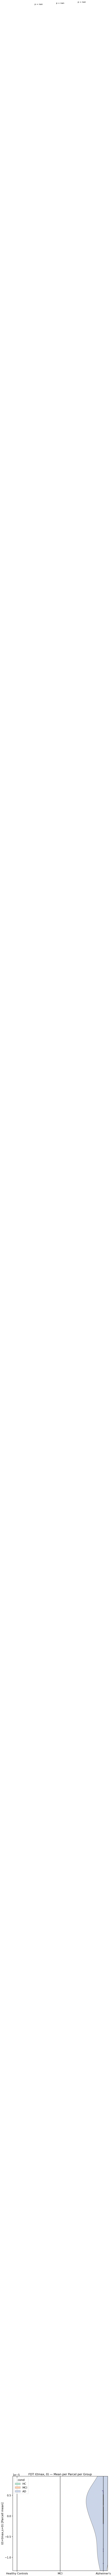

In [ ]:
#print( I_FDT_all[2,9,:]) # group index, subject index, parcel index
I_FDT_group_mean = np.nanmean(I_FDT_all, axis=1)
I_FDT_subject_mean = np.nanmean(I_FDT_all, axis=2)
#print(I_FDT_group_mean[0,:]) # the group mean for: group index, parcel index

group_names = ['HC', 'MCI', 'AD']
records_parcel = []
records_subject = []

for group_idx, group_name in enumerate(group_names):
    for parcel in range(I_FDT_group_mean.shape[1]):
        records_parcel.append({
            "value": I_FDT_group_mean[group_idx, parcel],
            "cond": group_name,
            "parcel": parcel
        })

for groupidx, group_name in enumerate(group_names):
    for subject in range(I_FDT_subject_mean.shape[1]):
        records_subject.append({
            "value": I_FDT_subject_mean[groupidx, subject],
            "cond": group_name,
            "subject": subject
        })



data_parcels = pd.DataFrame.from_records(records_parcel)
data_subjects = pd.DataFrame.from_records(records_subject)

fig, ax = plt.subplots(figsize=(10, 10))

plot_violins_HC_MCI_AD(
    ax=ax,
    data=data_parcels,
    font_scale=1.4,
    metric='I(t=tmax,s=0) [Parcell mean]',
    point_size=5,
    xgrid=False,
    plot_title='FDT I(tmax, 0) — Mean per parcel per group',
    saveplot=1,
    dpi=300
)

fig, ax = plt.subplots(figsize=(10, 10))

plot_violins_HC_MCI_AD(
    ax=ax,
    data=data_subjects,
    font_scale=1.4,
    metric='I(t=tmax,s=0) [Subject mean]',
    point_size=5,
    xgrid=False,
    plot_title='FDT I(tmax, 0) — Mean per subject per group',
    saveplot=1,
    dpi=300
)

# import p_values as p_values  # Make sure this is working!


# # Create dictionary like in loadResultsCohort demo
# resI = {
#     'HC': I_HC,
#     'MCI': I_MCI,
#     'AD': I_AD
# }

# # Plot
# plt.rcParams.update({'font.size': 15})
# p_values.plotComparisonAcrossLabels2(
#     resI,
#     columnLables=['HC', 'MCI', 'AD'],
#     graphLabel='FDT I(tmax, 0) Parcels'
# )

# print("done!")

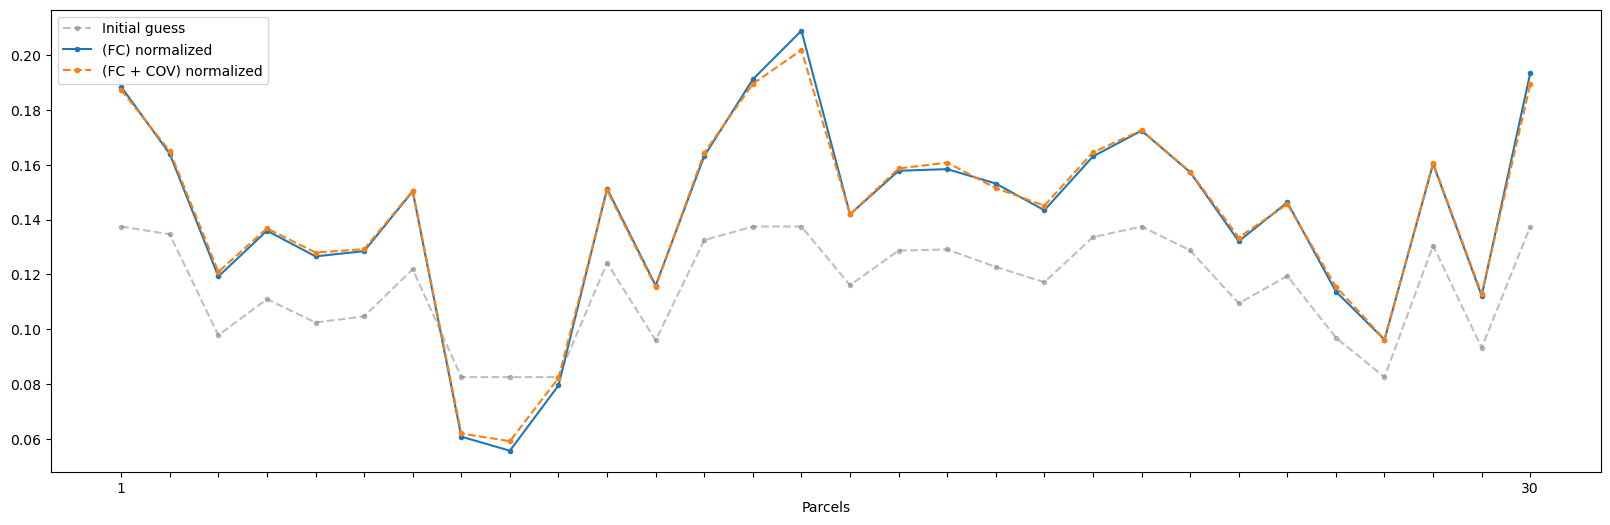

[0.1375     0.13465865 0.09778608 0.11099456 0.10244673 0.10468258
 0.12192867 0.0825     0.0825     0.0825     0.12424738 0.09593643
 0.13253443 0.1375     0.1375     0.11608289 0.12873806 0.12912674
 0.12275555 0.11718317 0.13364243 0.1375     0.12880848 0.10943069
 0.11945811 0.09691293 0.0825     0.13053999 0.09318363 0.1375    ]
[0.18854697 0.1640493  0.1192675  0.13598006 0.12661182 0.12850366
 0.15036515 0.06075974 0.05561807 0.07946091 0.15136982 0.11594241
 0.16326004 0.19126966 0.20902361 0.14196664 0.15787206 0.15846807
 0.15321608 0.14345639 0.16310709 0.17252151 0.157337   0.13213841
 0.14631922 0.11375646 0.09618854 0.16039344 0.11225646 0.19356756]


In [ ]:
plt.figure(figsize=(np.clip(NPARCELLS, 10, 20),6))
plt.plot(range(1, NPARCELLS+1), initial_sigma, '.--', color='gray', alpha=0.5, label='Initial guess')
# plt.plot(range(1, NPARCELS+1), initial_sigma_norm, '*--', color='gray', markersize=10, alpha=0.5, label='Initial guess normalized')
plt.plot(range(1, NPARCELLS+1), sigma_final_norm_fc, '.-', color='tab:blue', alpha=1, label='(FC) normalized')
plt.plot(range(1, NPARCELLS+1), sigma_final_norm_fccv, '.--', color='tab:orange', alpha=1, label='(FC + COV) normalized')
plt.xlabel('Parcels')
ticks = np.arange(1, NPARCELLS + 1)
labels = [str(ticks[0])] + [''] * (len(ticks) - 2) + [str(ticks[-1])]
plt.xticks(ticks,labels)
plt.legend()
plt.show()

(60,)


In [135]:
### Check if the system is stable, i.e. Re(eigenvalues_of_Gamma)>0
eigenvalues_of_Gamma = np.linalg.eigvals(Gamma)
is_stable = np.all(np.real(eigenvalues_of_Gamma) > 0)
print(is_stable)
tol = 1e-12
is_stable = np.all(np.real(eigenvalues_of_Gamma) > tol)
print(is_stable)

True
True


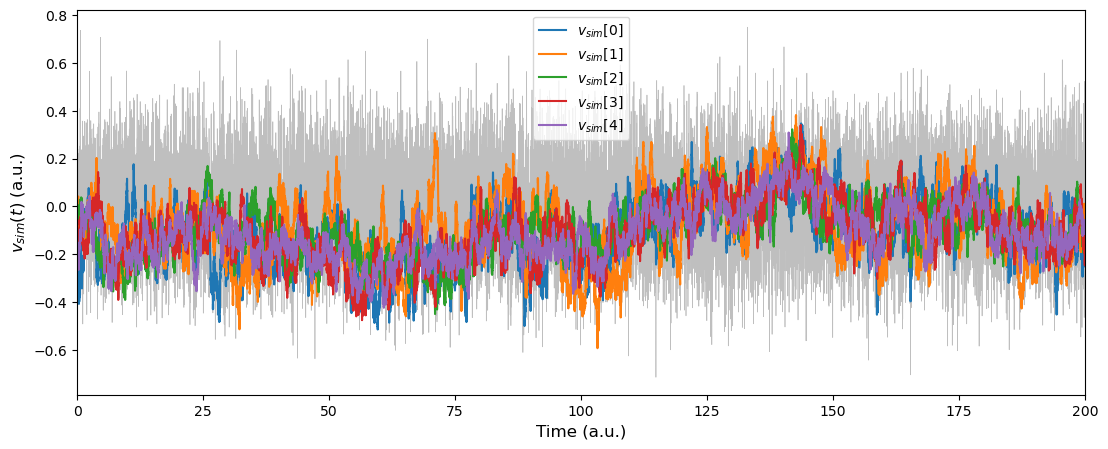

In [ ]:
### Check the system and THERMALIZATION (if THERMALIZATION == 1)



NPARCELLS_plot = NPARCELLS
if NPARCELLS > 5:
    NPARCELLS_plot = 5

plt.figure(figsize=(13,5))
plt.plot(times, noise[0,:], lw=0.5, color='gray', alpha=0.5)
for i in range(NPARCELLS_plot):
    plt.plot(times, vsim[i,:], label=r'$v_{sim}[%d]$'%i)
plt.xlim(0,tfinal)
plt.ylabel(r'$v_{sim}(t)$ (a.u.)', fontsize=12)
plt.xlabel('Time (a.u.)', fontsize=12)
plt.legend()
plt.show()
    

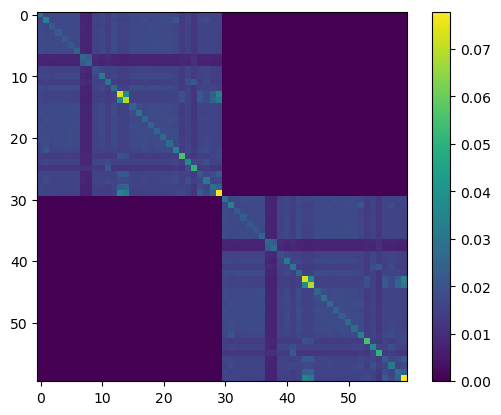

In [144]:
D = np.diag(sigma**2 * np.ones(Ndim))
V_0 = solve_continuous_lyapunov(Gamma, D)
plt.imshow(V_0)
plt.colorbar()
plt.show()

(60, 60)
(60,)
(60, 60)


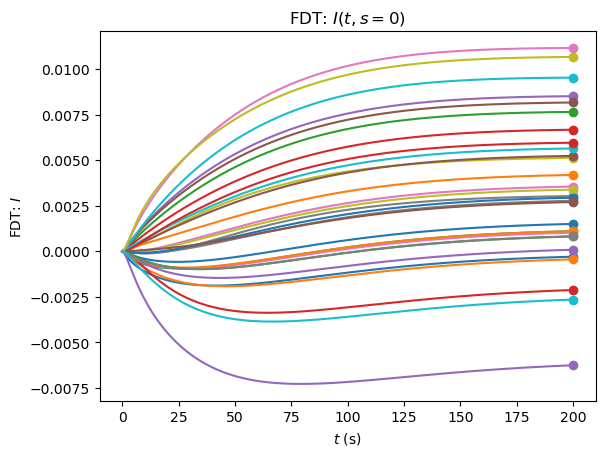

In [ ]:


plt.title(r'FDT: $I(t,s=0)$')
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'FDT: $I$')
plt.show()
plt.show()

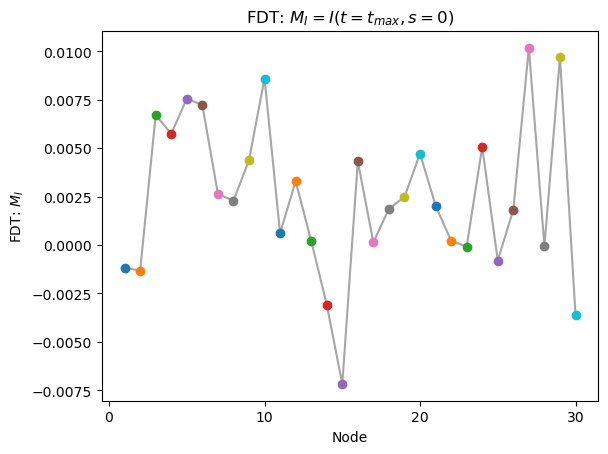

In [ ]:


plt.plot(np.arange(NPARCELLS)+1, I_tmax_s0,'.-',color='gray',alpha=0.7)
plt.gca().set_prop_cycle(None)
for par in range(NPARCELLS):
    plt.plot(par+1,I_tmax_s0[par],'o-')

plt.title(r'FDT: $M_I=I(t=t_{max},s=0)$')
plt.xlabel('Node')
plt.ylabel(r'FDT: $M_I$')
x_ticks = 10 if NPARCELLS > 20 else 1
plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))
plt.show()

In [ ]:
if 'I_HC' in locals() and 'I_MCI' in locals() and 'I_AD' in locals():
    datasets = [I_HC, I_MCI, I_AD]
    labels = ['HC', 'MCI', 'AD']

    data = pd.DataFrame({
        "value": np.concatenate([I_HC, I_MCI, I_AD]),
        "cond": ["HC"] * len(I_HC) + ["MCI"] * len(I_MCI) + ["AD"] * len(I_AD),
    })
    filename = f"FDT_I_Violinplot_par_COND_{COND}"

    fig, ax = plt.subplots(figsize=(10, 10))
    #fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

    plot_violins_HC_MCI_AD(ax=ax, data=data,
            font_scale=1.4, 
            metric='I(t=tmax,s=0) [Parcells]',
            point_size = 4,
            xgrid=False,
            plot_title='FDT I(tmax, 0) Parcells',
            saveplot = 1,
            filename=filename,
            dpi=300)
    
    print('Mean HC  =',np.mean(I_HC))
    print('Mean MCI =',np.mean(I_MCI))
    print('Mean AD =',np.mean(I_AD))

In [76]:
### Calculation of V_0 = < v_0 v_0^T >
if THERMALIZATION == 1:
    ### Perform explicit THERMALIZATION (it was OK, but no longer needed!)
    # Nsim = 10000
    # THERMALIZATION_time = 100
    # dt = 0.1 * TR / 2
    # V_0 = np.zeros_like(Gamma)
    # for i in range(Nsim):
    #     v0 = v0std*np.random.standard_normal(Ndim) + v0bias
    #     vsim, noise = Integrate_Langevin_ND_Optimized(Gamma, sigma, initcond=v0, duration=THERMALIZATION_time, integstep=dt)
    #     v0 = vsim[:, -1]
    #     V_0 += V_0_calculation_v0fixed(v0)
    # V_0 /= Nsim
    # V_0_sim = V_0
    ### Calculate Vterm with the Lyapunov equation
    D = np.diag(sigma**2 * np.ones(Ndim))
    V_0 = solve_continuous_lyapunov(Gamma, D)
else:
    ndim = np.shape(Gamma)[0]
    V_0 = V_0_calculation_v0gauss(v0std, v0bias, ndim)


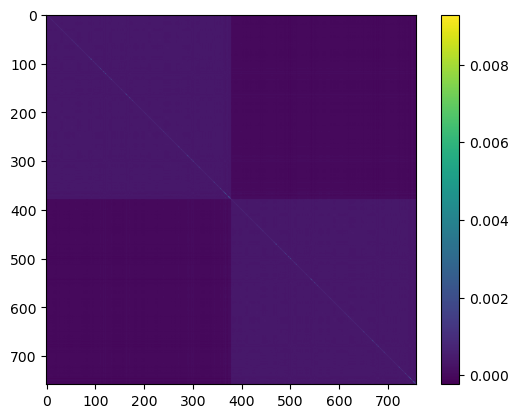

In [77]:
### Plot V_0
plt.imshow(V_0)
plt.colorbar()
plt.show()

---

# Define the timeframe for the calculation



In [78]:
# Define the temporal resolution for the calculations
t0 = 0
tfinal = 200
dt = 1.0

times = np.arange(t0, tfinal+dt, dt)
nsteps = len(times)

---

# Calculation of $V$ (optional, to see the plots of $V(t,s)$ as a function of $t$ or $s$)

In [79]:
### To integrate V we have to calculate the the whole matrices --> it takes too long!
V_CALCULATION = 0

In [80]:
if V_CALCULATION == 1:
    t_times = times[0:nsteps]
    s_times = times[0:nsteps]

    Vts_calc = np.zeros((NPARCELLS,len(t_times),len(s_times)))
    for t in range(len(t_times)):
        for s in range(0,t):
            Vts_calc[:,t,s] = Vts_Langevin_ND(Gamma, sigma, V_0, t_times[t], s_times[s])[0:NPARCELLS] ## I calculate ONLY the x components

In [81]:
# size = nsteps
# LowerDiag = np.tri(size, size)
# for i in range(NPARCELLS):
#     Vts_calc[i,:,:] = np.multiply(Vts_calc[i,:,:], LowerDiag)

In [82]:
if V_CALCULATION == 1:
    plot_matrices(Vts_calc,max_columns=2,title='V(t,s)')

---

### Plot the rows of V

In [83]:
if V_CALCULATION == 1:
    for tn in [50, 100, -1]:
        for dim in range(0,1):#NPARCELLS):
            plt.plot(times, Vts_calc[dim,tn,:], label=f't=%.3f'%times[tn])
    plt.title(f'FDT: V(t,s=0) (rows of the matrices)')
    plt.xlabel('Time [s]')
    plt.ylabel('FDT: V(t,s=0)')
    plt.legend()
    plt.show()

### Integration of $V(t,s)$ over s:
$$ V_s(t) = \int_{0}^{t} V(t,s) ds $$

Obs.: this should be $V_s(t) = I(t,0)$

In [84]:
if V_CALCULATION == 1:
    # Integrate V(t,s) over s
    V_ints = np.zeros((NPARCELLS,nsteps))
    for t_int in range(0,nsteps):
        t = times[t_int]
        V_ints[:,t_int] = numerical_integration_of_Vts_in_s(t, Gamma, V_0, sigma)[0:NPARCELLS]
    for par in range(NPARCELLS):
        plt.plot(times, V_ints[par,:])
    plt.title(r'FDT: $V_s(t)=\int_0^{t} V(t,s)ds$')
    plt.xlabel('Time [t]')
    plt.ylabel('V-FDT')
    plt.show()


Now integration of $V_s(t)$ over $t$

In [85]:
if V_CALCULATION == 1:
    # Integrate Vs(t) over t
    x = times[0:nsteps]
    V_ints_intt = np.zeros(NPARCELLS)
    for par in range(NPARCELLS):
        y = V_ints[par,:]
        V_ints_intt[par] = integrate.trapezoid(y, x=x)

    # Plot Vts for each node
    plt.plot(np.arange(NPARCELLS)+1,V_ints_intt,'.-',color='gray',alpha=0.7)
    plt.gca().set_prop_cycle(None)
    for par in range(NPARCELLS):
        plt.plot(par+1,V_ints_intt[par],'o')
    x_ticks = 10 if NPARCELLS > 20 else 1
    plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))
    plt.title(r'FDT: $V_{ts}=\int_0^{tmax} V_s(t)dt$')
    plt.xlabel('Node')
    plt.ylabel(r'FDT: $V_{st}$')
    plt.show()


The integration of $V(t,s)$ over $s$ and $t$ increases with increasing $t_{max}$. So **it is NOT a good metric**\
Instead, I plot $V_s(t=t_{max})=I(t_{max},0)$ for each node, i.e. integration of the last row:

In [86]:
if V_CALCULATION == 1:
    plt.plot(np.arange(NPARCELLS)+1,V_ints[:,-1],'.-',color='gray',alpha=0.7)
    plt.gca().set_prop_cycle(None)
    for par in range(NPARCELLS):
        plt.plot(par+1,V_ints[par,-1],'o')

    plt.title(r'FDT: $V_s(t_{max})=\int_0^{tmax} V(t_{max},s)ds$')
    plt.xlabel('Node')
    plt.ylabel(r'FDT: $V_s(t_{max})$')
    x_ticks = 10 if NPARCELLS > 20 else 1
    plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))
    plt.show()

---

# Calculation of $I$

**OBS:** as it happens also with $V(t,s)$, integrating $I(t,s)$ over $t$ and $s$ is not a good choice because it gets larger as the observation time increases.\
Therefore a **good metric** for $I$ would be $I(t_{max},0)$.

In [87]:
I_CALCULATION = 1

(758, 758)
(758,)
(758, 758)


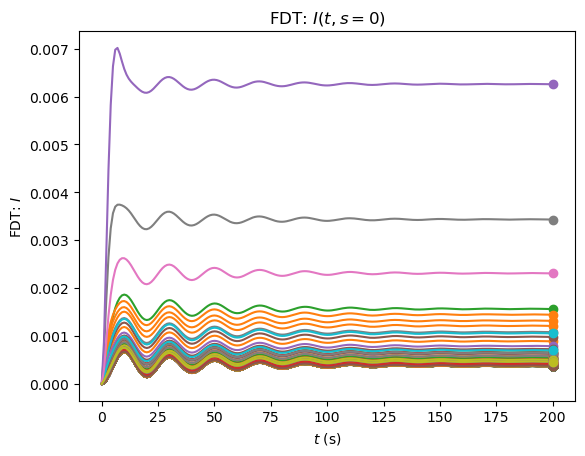

In [88]:
if I_CALCULATION == 1:
    t_times = times[0:nsteps]
    s_times = times[0:nsteps]

    Its_calc = np.zeros((NPARCELLS,len(t_times)))
    print(Gamma.shape)
    print(sigma.shape)
    print(V_0.shape)
    for t in range(len(t_times)):
        Its_calc[:,t] = Its_Langevin_ND(Gamma, sigma, V_0, t_times[t], s_times[0])[0:NPARCELLS] # I keep ONLY for the x-components

    for par in range(NPARCELLS):
        plt.plot(times, Its_calc[par,:])
    plt.gca().set_prop_cycle(None)
    for par in range(NPARCELLS):
        plt.plot(times[-1],Its_calc[par,-1],'o')

    plt.title(r'FDT: $I(t,s=0)$')
    plt.xlabel(r'$t$ (s)')
    plt.ylabel(r'FDT: $I$')
    plt.show()
    plt.show()

Calculation and plot of $I(t_{max}=200,s=0)$ for each node

In [89]:
tmax = 100
ts = 0
I_tmax_s0 = Its_Langevin_ND(Gamma, sigma, V_0, tmax, ts)[0:NPARCELLS]

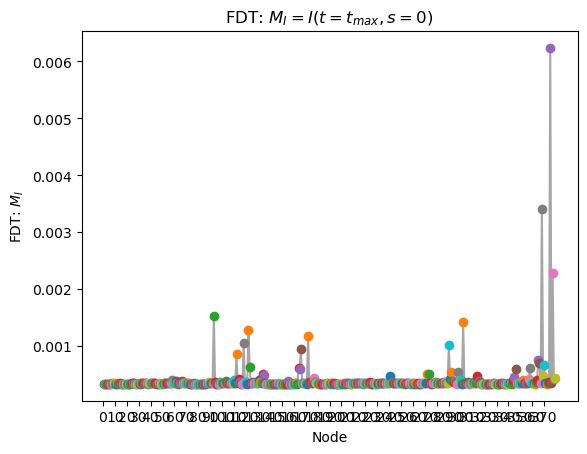

In [90]:
plt.plot(np.arange(NPARCELLS)+1, I_tmax_s0,'.-',color='gray',alpha=0.7)
plt.gca().set_prop_cycle(None)
for par in range(NPARCELLS):
    plt.plot(par+1,I_tmax_s0[par],'o-')

plt.title(r'FDT: $M_I=I(t=t_{max},s=0)$')
plt.xlabel('Node')
plt.ylabel(r'FDT: $M_I$')
x_ticks = 10 if NPARCELLS > 20 else 1
plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))
plt.show()


---

### Comparisson between $V$ and $I$

In [91]:
V_I_COMPARISSON = 0

In [92]:
if V_I_COMPARISSON == 1:
    intV_s0_tmax = numerical_integration_of_Vts_in_s(tmax, Gamma, V_0, sigma)[0:NPARCELLS]
    I_numerical = compute_I_as_numerical_integration_of_V(tmax, 0, Gamma, V_0, sigma)[0:NPARCELLS]

    plt.plot(np.arange(NPARCELLS)+1,intV_s0_tmax,'o-')
    plt.plot(np.arange(NPARCELLS)+1,I_tmax_s0,'*-')
    plt.plot(np.arange(NPARCELLS)+1,I_numerical,'.--')

    plt.title(r'FDT: $M_I=I(t_{max},s=0)$')
    plt.xlabel('Node')
    plt.ylabel(r'FDT: $M_I$')
    x_ticks = 10 if NPARCELLS > 20 else 1
    plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))
    plt.show()

    ###

    from scipy.stats import linregress

    x = intV_s0_tmax
    y = I_tmax_s0
    slope, intercept, r, p, se = linregress(x, y)

    plt.plot(x, y , 'o')
    plt.plot(np.sort(x), slope * np.sort(x) + intercept, '--', color='gray', alpha=0.7, label=r'$R=r^2$=%f'%r**2)
    plt.xlabel('Vs(tmax)')
    plt.ylabel('I(tmax.s=0)')
    plt.legend()
    plt.show()

    ###

    from scipy.stats import pearsonr
    from scipy.stats import spearmanr
    from scipy.stats import kendalltau

    ### FDT Mi vs LZC Deep-sleep
    distribution1 = V_ints_intt
    distribution2 = I_tmax_s0
    # Pearson Correlation Coefficient 
    r, p_value = pearsonr(distribution1, distribution2)
    print('FDT Mi vs LZC N3, Pearson r :',r)
    # Spearman\'s Rank Correlation
    rho, p_value = spearmanr(distribution1, distribution2)
    print('FDT Mi vs LZC N3, Spearman\'s Rank rho :',rho)
    # Kendall\'s Tau
    tau, p_value = kendalltau(distribution1, distribution2)
    print('FDT Mi vs LZC N3, Kendall\'s Tau :',tau)

---

### Plot boxplots

In [93]:

if COND == 1:
    I_W = I_tmax_s0
if COND == 2:
    I_N3 = I_tmax_s0
if COND == 3:
    I_HC = I_tmax_s0
if COND == 4:
    I_MCI = I_tmax_s0
if COND == 5:
    I_AD = I_tmax_s0

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 77.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 80.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 73.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 83.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/cat

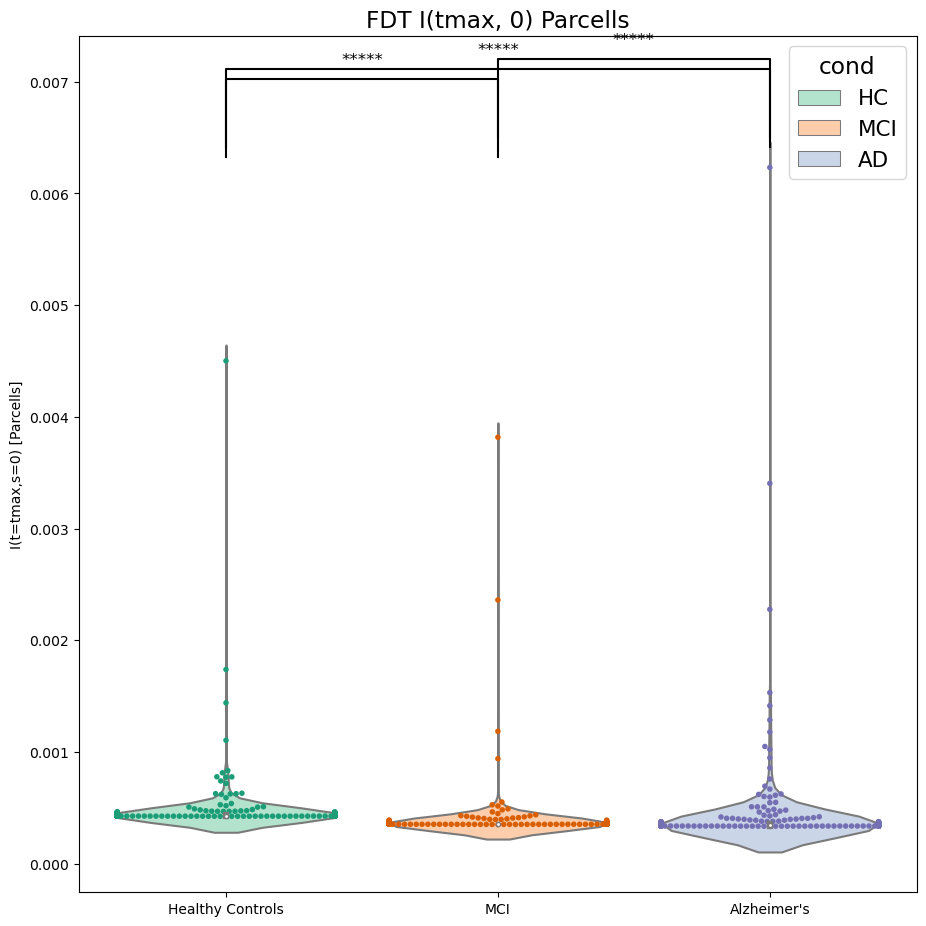

Mean HC  = 0.0004637807524360072
Mean MCI = 0.0003813960978382636
Mean AD = 0.0004056061189854289


In [94]:
if 'I_HC' in locals() and 'I_MCI' in locals() and 'I_AD' in locals():
    datasets = [I_HC, I_MCI, I_AD]
    labels = ['HC', 'MCI', 'AD']

    if SAMESIGMA == 1:
        filename = f"Dataset_W-N3_fig_MI_I(tmx,s=0)_SAMESIGMA_{SAMESIGMA}"
    else:
        filename = f"Dataset_W-N3_fig_MI_I(tmx,s=0)_SAMESIGMA_{SAMESIGMA}_HETERO_{HETEROGENEOUS}"

    data = pd.DataFrame({
        "value": np.concatenate([I_HC, I_MCI, I_AD]),
        "cond": ["HC"] * len(I_HC) + ["MCI"] * len(I_MCI) + ["AD"] * len(I_AD),
    })
    filename = f"FDT_I_Violinplot_par_COND_{COND}"

    fig, ax = plt.subplots(figsize=(10, 10))
    #fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

    plot_violins_HC_MCI_AD(ax=ax, data=data,
            font_scale=1.4, 
            metric='I(t=tmax,s=0) [Parcells]',
            point_size = 4,
            xgrid=False,
            plot_title='FDT I(tmax, 0) Parcells',
            saveplot = 1,
            filename=filename,
            dpi=300)
    
    print('Mean HC  =',np.mean(I_HC))
    print('Mean MCI =',np.mean(I_MCI))
    print('Mean AD =',np.mean(I_AD))

elif 'I_W' in locals() and 'I_N3' in locals():
    datasets = [I_W, I_N3]
    labels = ['W', 'N3']

    if SAMESIGMA == 1:
        filename = f"Dataset_W-N3_fig_MI_I(tmx,s=0)_SAMESIGMA_{SAMESIGMA}"
    else:
        filename = f"Dataset_W-N3_fig_MI_I(tmx,s=0)_SAMESIGMA_{SAMESIGMA}_HETERO_{HETEROGENEOUS}"

    data = pd.DataFrame({
        "value": np.concatenate([I_W, I_N3]),
        "cond": ["W"] * len(I_W) + ["N3"] * len(I_N3),
    })



    filename = f"FDT_I_Violinplot_par_COND_{COND}"

    fig, ax = plt.subplots(figsize=(5, 5))
    plot_violins_W_N3(ax=ax, data=data,
            font_scale=1.4, 
            metric='I(t=tmax,s=0) [Parcells]',
            point_size = 4,
            xgrid=False,
            plot_title='FDT I(tmax, 0) Parcells',
            saveplot = 1,
            filename=filename,
            dpi=300)
    
    print('Mean W  =',np.mean(I_W))
    print('Mean N3 =',np.mean(I_N3))


Averages and Std Dev:
HC: avg=0.0004637807524360072, stdev=0.0002325593300542387, len=379
MCI: avg=0.0003813960978382636, stdev=0.00021178694883760307, len=379
AD: avg=0.0004056061189854289, stdev=0.00037461403780904095, len=379

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HC vs. MCI: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.186e-110 U_stat=1.391e+05
MCI vs. AD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.091e-44 U_stat=1.141e+05
HC vs. AD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.045e-90 U_stat=1.324e+05


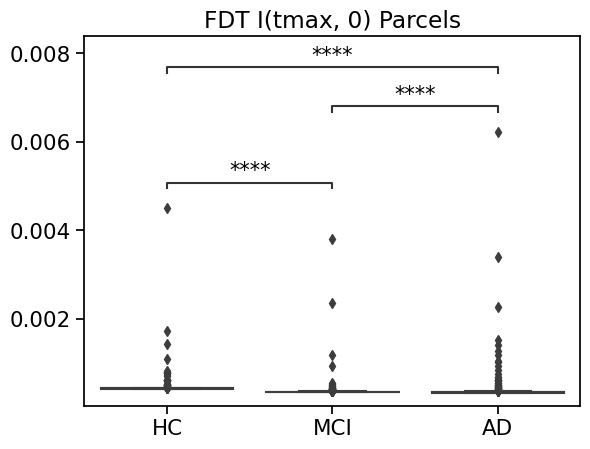

done!


---

# To-do 1
- Adapt the code to:
    - only calculate analytically. **DONE**
    - the use of empiric connectivities and frequencies. **DONE**
    - integrate |V(t,0)| and |I(t,0)| from t=0 to t=tfinal **DONE**
    - Change v0 to be the set after some simulated THERMALIZATION. **DONE**

# To-do 2
- Adapt the code to:
    - Calculate for all subjects in different conditions with out having to run it twice to make the boxplots :(